# Potato Plant Disease Detection Model Training

This notebook trains a convolutional neural network (CNN) to identify diseases in potato plants using image datasets.

## Import Required Libraries

In [9]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import keras
from keras import layers

# For TensorFlow 2.18.0, ImageDataGenerator is no longer in keras.preprocessing.image
# Instead, we need to use tf.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
import cv2
import glob
import random

## Load and Preprocess Dataset

In [10]:
# Define constants
IMG_SIZE = 224  # Common size for pretrained models
BATCH_SIZE = 32
EPOCHS = 20

# Define paths
dataset_path = "datasets"  # Updated path to match your directory structure

# Classes for potato diseases - updated to match your actual folder names
classes = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]

# Function to load and preprocess images
def load_data(dataset_path):
    images = []
    labels = []
    
    print(f"Looking for images in: {os.path.abspath(dataset_path)}")
    
    for idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        print(f"Processing class {class_name} from {class_path}")
        
        # Check if directory exists
        if not os.path.exists(class_path):
            print(f"Warning: Directory {class_path} does not exist!")
            continue
            
        image_files = glob.glob(os.path.join(class_path, "*.JPG"))
        print(f"Found {len(image_files)} images in {class_name}")
        
        for img_path in image_files:
            try:
                # Read and resize image
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not read image {img_path}")
                    continue
                    
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                
                # Normalize image
                img = img / 255.0
                
                images.append(img)
                labels.append(idx)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                
    return np.array(images), np.array(labels)

# Load the dataset
print("Loading and preprocessing the dataset...")
X, y = load_data(dataset_path)

if len(X) == 0:
    print("No images were loaded! Please check the dataset path and image formats.")
else:
    print(f"Total images loaded: {len(X)}")
    print(f"Image shape: {X[0].shape}")
    print(f"Classes: {classes}")

Loading and preprocessing the dataset...
Looking for images in: d:\Harsh\my work\plant disease detection\plant_detection\datasets
Processing class Potato___Early_blight from datasets\Potato___Early_blight
Found 1000 images in Potato___Early_blight
Processing class Potato___Late_blight from datasets\Potato___Late_blight
Found 1000 images in Potato___Late_blight
Processing class Potato___Late_blight from datasets\Potato___Late_blight
Found 1000 images in Potato___Late_blight
Processing class Potato___healthy from datasets\Potato___healthy
Found 152 images in Potato___healthy
Processing class Potato___healthy from datasets\Potato___healthy
Found 152 images in Potato___healthy
Total images loaded: 2152
Image shape: (224, 224, 3)
Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Total images loaded: 2152
Image shape: (224, 224, 3)
Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


## Visualize Sample Images

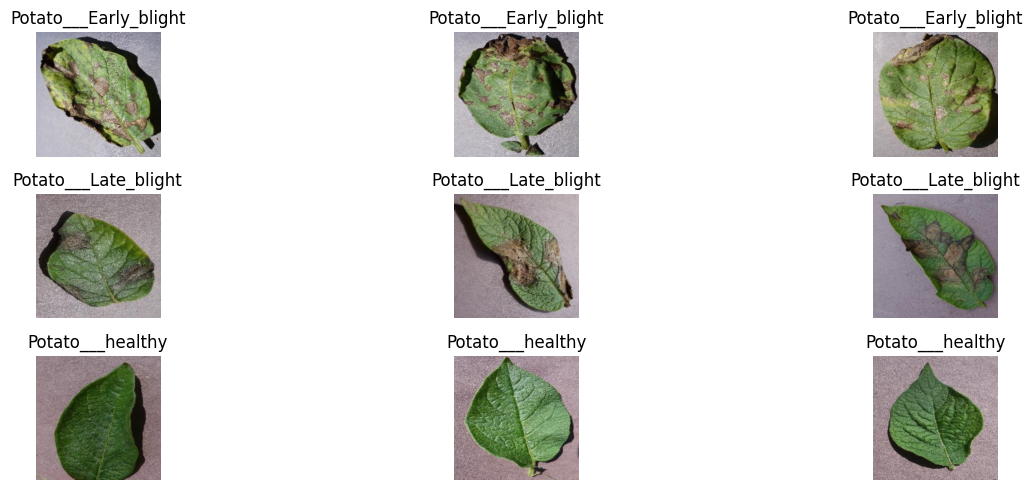

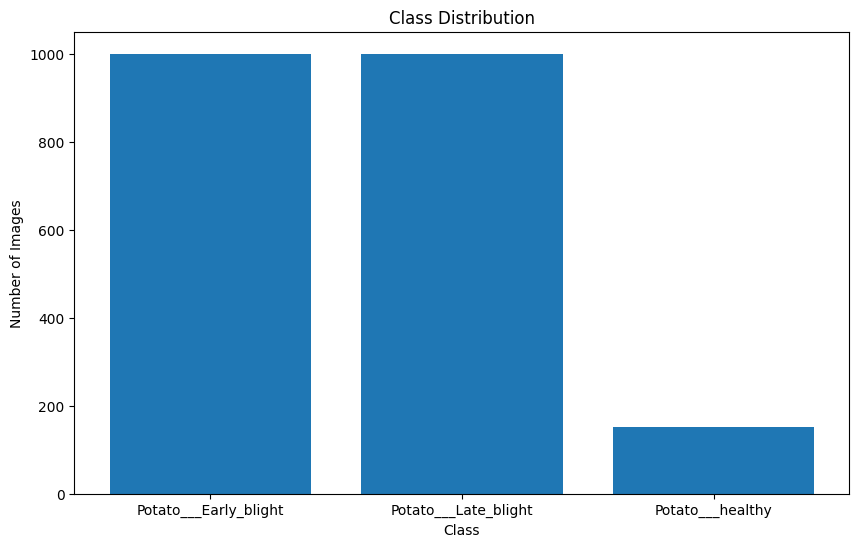

In [11]:
# Display random samples from each class
plt.figure(figsize=(15, 5))

for i, class_name in enumerate(classes):
    # Find indices for this class
    indices = np.where(y == i)[0]
    
    # Get 3 random samples
    sample_indices = random.sample(list(indices), min(3, len(indices)))
    
    for j, idx in enumerate(sample_indices):
        plt.subplot(len(classes), 3, i*3 + j + 1)
        plt.imshow(X[idx])
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()

# Visualize class distribution
plt.figure(figsize=(10, 6))
class_counts = [np.sum(y == i) for i in range(len(classes))]
plt.bar(classes, class_counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

## Split Dataset into Training and Validation Sets

In [12]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, len(classes))
y_val = keras.utils.to_categorical(y_val, len(classes))

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Training samples: 1721
Validation samples: 431


## Data Augmentation

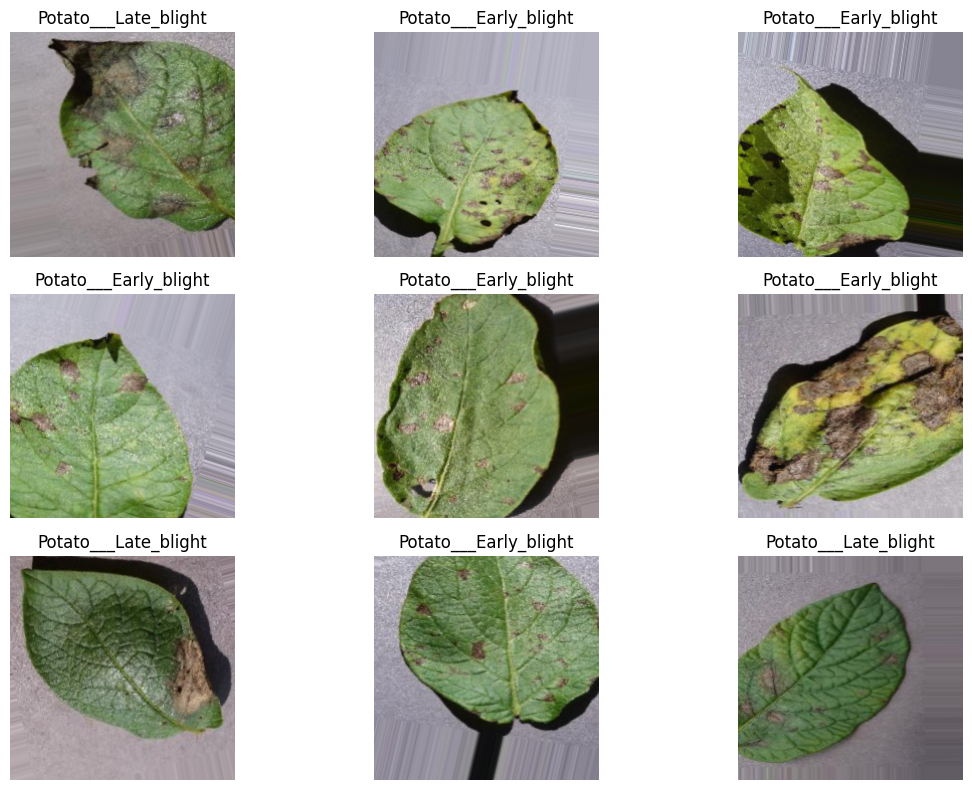

In [13]:
# Create data generators for training with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data should not be augmented
val_datagen = ImageDataGenerator()

# Create generators
train_generator = train_datagen.flow(
    X_train, 
    y_train,
    batch_size=BATCH_SIZE
)

val_generator = val_datagen.flow(
    X_val,
    y_val,
    batch_size=BATCH_SIZE
)

# Display some augmented images
def show_augmented_images():
    X_batch, y_batch = next(train_generator)
    
    plt.figure(figsize=(12, 8))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.argmax(y_batch[i])])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_augmented_images()

## Define the Model Architecture

In [14]:
# Define CNN model architecture
def create_model():
    # Option 1: Custom CNN from scratch
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dense(len(classes), activation='softmax')
    ])
    
    return model

# Option 2: Transfer Learning with MobileNetV2
def create_transfer_learning_model():
    base_model = keras.applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    # Create the model
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(classes), activation='softmax')
    ])
    
    return model

# Choose which model to use
model = create_transfer_learning_model()

# Display model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Compile the Model

In [15]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Train the Model

In [16]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='best_potato_disease_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Calculate steps per epoch
steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.7189 - loss: 0.7389
Epoch 1: val_accuracy improved from -inf to 0.94712, saving model to best_potato_disease_model.h5

Epoch 1: val_accuracy improved from -inf to 0.94712, saving model to best_potato_disease_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 466ms/step - accuracy: 0.7211 - loss: 0.7333 - val_accuracy: 0.9471 - val_loss: 0.1719
Epoch 2/20
Epoch 2/20
 1/53 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - accuracy: 0.9688 - loss: 0.1415

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.94712 to 0.94952, saving model to best_potato_disease_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9688 - loss: 0.1415 - val_accuracy: 0.9495 - val_loss: 0.1702
Epoch 3/20
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9384 - loss: 0.1840
Epoch 3: val_accuracy improved from 0.94952 to 0.95673, saving model to best_potato_disease_model.h5

Epoch 3: val_accuracy improved from 0.94952 to 0.95673, saving model to best_potato_disease_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 446ms/step - accuracy: 0.9384 - loss: 0.1839 - val_accuracy: 0.9567 - val_loss: 0.1271
Epoch 4/20
Epoch 4/20
 1/53 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - accuracy: 0.9688 - loss: 0.0860
Epoch 4: val_accuracy did not improve from 0.95673
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9688 - loss: 0.0860 - val_accuracy: 0.9567 - val_loss: 0.1279
Epoch 5/20

Epoch 4: val_accuracy did not improve from 0.95673
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9688 - loss: 0.0860 - val_accuracy: 0.9567 - val_loss: 0.1279
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9450 - loss: 0.1398
Epoch 5: val_accuracy did not improve from 0.95673
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 444ms/step - accuracy: 0.9451 - loss: 0.1395 - val_accuracy: 0.9447 - val_loss: 0.1310
Epoch 6/20

Epoch 5: val_accuracy did not improve from 0.95673
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 444ms/step - accuracy: 0.9451 - loss: 0.1395 - val_accuracy: 0.9447 - val_loss: 0.1310
Ep

## Evaluate Model Performance

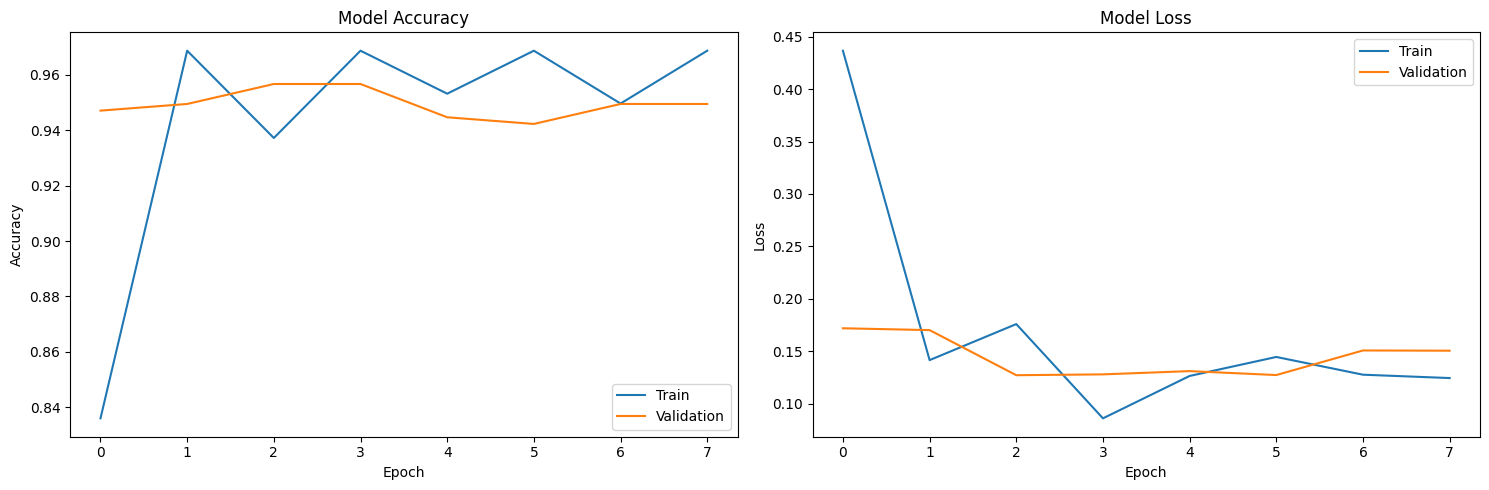

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - accuracy: 0.9539 - loss: 0.1291
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - accuracy: 0.9539 - loss: 0.1291
Validation Loss: 0.1273
Validation Accuracy: 0.9567
Validation Loss: 0.1273
Validation Accuracy: 0.9567
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

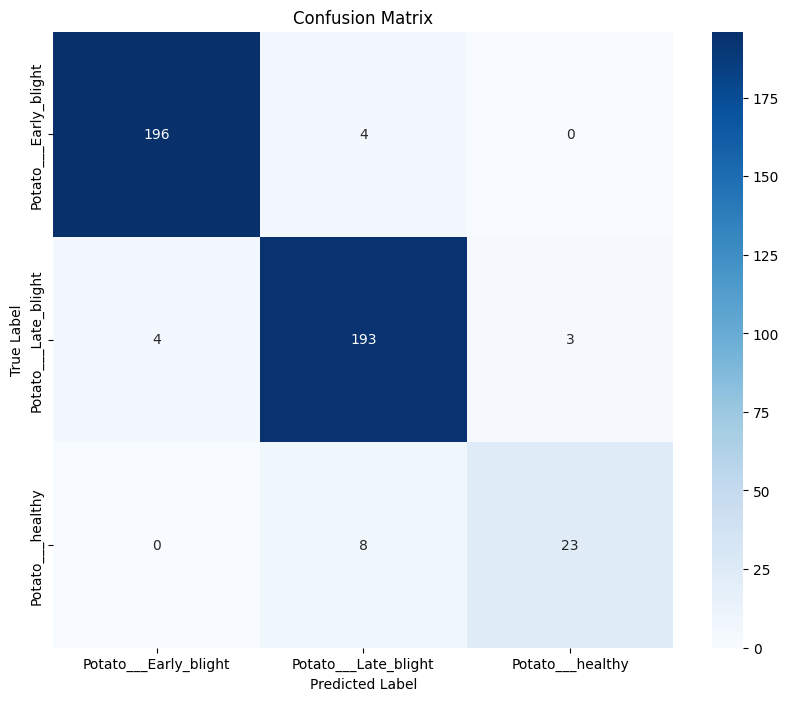

Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       0.98      0.98      0.98       200
 Potato___Late_blight       0.94      0.96      0.95       200
     Potato___healthy       0.88      0.74      0.81        31

             accuracy                           0.96       431
            macro avg       0.94      0.90      0.91       431
         weighted avg       0.96      0.96      0.96       431



In [17]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'], loc='lower right')
    
    # Loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_generator, steps=validation_steps)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
y_pred = []
y_true = []

for i in range(len(X_val)):
    pred = model.predict(X_val[i:i+1])
    y_pred.append(np.argmax(pred))
    y_true.append(np.argmax(y_val[i]))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

## Save the Trained Model

Model saved to potato_disease_detection_model.h5
TensorFlow.js module not found. Skipping conversion to TensorFlow.js format.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


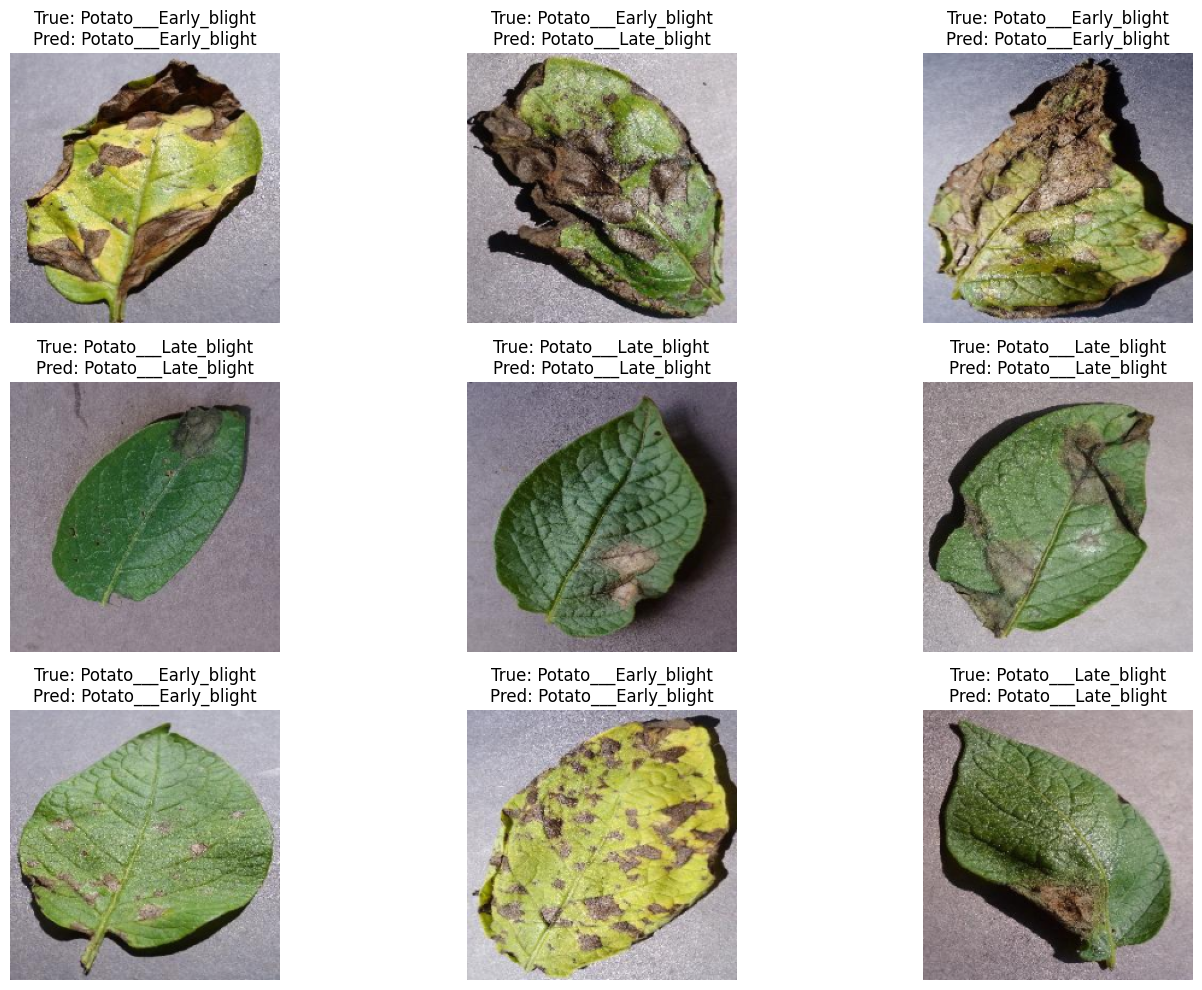

In [18]:
# Save the model
model_save_path = 'potato_disease_detection_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Save model in TensorFlow.js format for web deployment (optional)
try:
    import tensorflowjs as tfjs
    tfjs_model_dir = 'tfjs_potato_model'
    tfjs.converters.save_keras_model(model, tfjs_model_dir)
    print(f"Model saved in TensorFlow.js format at {tfjs_model_dir}")
except ImportError:
    print("TensorFlow.js module not found. Skipping conversion to TensorFlow.js format.")

# Test prediction on a few sample images
def predict_sample_images():
    plt.figure(figsize=(15, 10))
    for i in range(9):
        idx = random.randint(0, len(X_val)-1)
        img = X_val[idx]
        true_label = np.argmax(y_val[idx])
        
        # Make prediction
        pred = model.predict(np.expand_dims(img, axis=0))[0]
        pred_label = np.argmax(pred)
        
        # Display
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

predict_sample_images()

## Conclusion

The trained model can now identify three different potato plant conditions:
1. Early Blight
2. Late Blight
3. Healthy plants

This model can be deployed on mobile or web applications to help farmers quickly identify plant diseases in the field.